 # Project 4: Advanced Time Series Sales Forecasting

In [22]:
# Import Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# For time-series specific functionality
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm 

# For modeling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
%matplotlib inline


In [23]:
# Load the built-in Air Passengers dataset
data = sm.datasets.get_rdataset("AirPassengers", "datasets").data
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'])

# Display basic information
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
#data.head()
display(data)

Dataset shape: (144, 2)

First few rows:


,Month,Passengers
0,1970-01-01 00:00:00.000001949,112
1,1970-01-01 00:00:00.000001949,118
2,1970-01-01 00:00:00.000001949,132
3,1970-01-01 00:00:00.000001949,129
4,1970-01-01 00:00:00.000001949,121
...,...,...
139,1970-01-01 00:00:00.000001960,606
140,1970-01-01 00:00:00.000001960,508
141,1970-01-01 00:00:00.000001960,461
142,1970-01-01 00:00:00.000001960,390


In [24]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
Month         0
Passengers    0
dtype: int64


In [25]:
# Basic Stats
print("\nPassenger statistics:")
print(data['Passengers'].describe())


Passenger statistics:
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Passengers, dtype: float64


In [26]:
# Check the date range
print("\nDate range:")
print(f"Start: {data['Month'].min()}")
print(f"End: {data['Month'].max()}")


Date range:
Start: 1970-01-01 00:00:00.000001949
End: 1970-01-01 00:00:00.000001960


In [27]:
# Load the built-in Air Passenger Dataset
data = sm.datasets.get_rdataset("AirPassengers", "datasets").data
data.columns = ['Month', 'Passengers']



In [28]:
# Create proper date range
data['Month'] = pd.date_range(start='1949-01-01', periods=len(data), freq='ME')
# Display basic information
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
display(data)


Dataset shape: (144, 2)

First few rows:


,Month,Passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121
...,...,...
139,1960-08-31,606
140,1960-09-30,508
141,1960-10-31,461
142,1960-11-30,390


In [29]:
# Check the date range again
print("\nDate range:")
print(f"Start: {data['Month'].min()}")
print(f"End: {data['Month'].max()}")


Date range:
Start: 1949-01-31 00:00:00
End: 1960-12-31 00:00:00


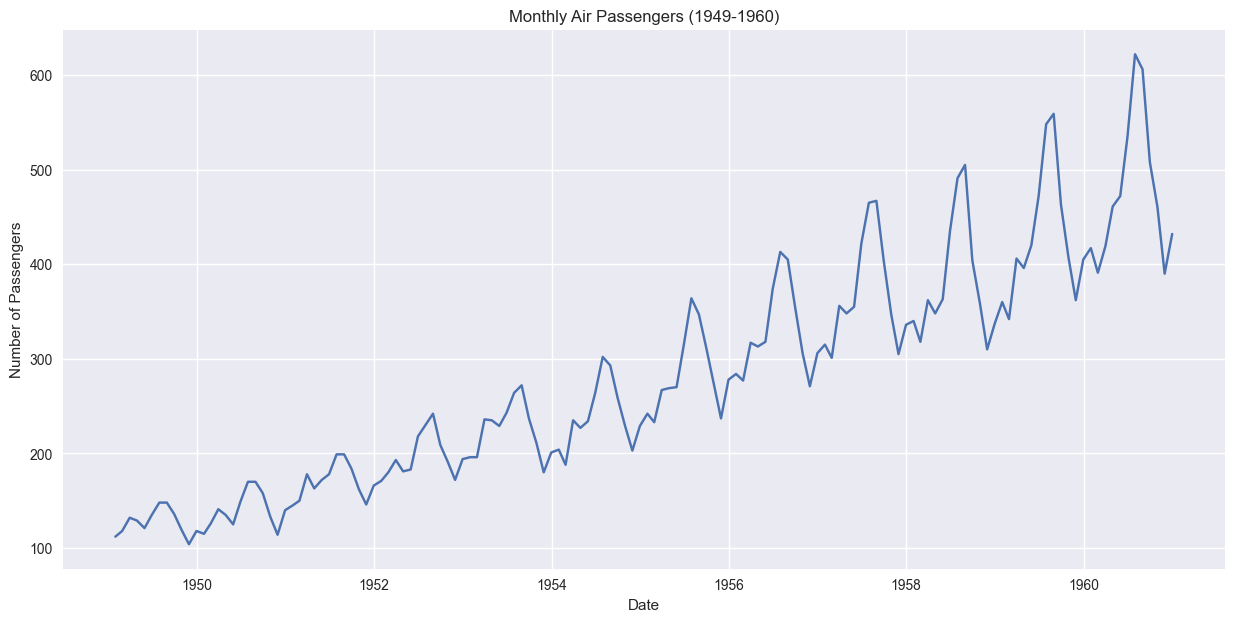

In [30]:
# Plot the time series data
plt.figure(figsize=(15, 7))
plt.plot(data['Month'], data['Passengers'])
plt.title('Monthly Air Passengers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

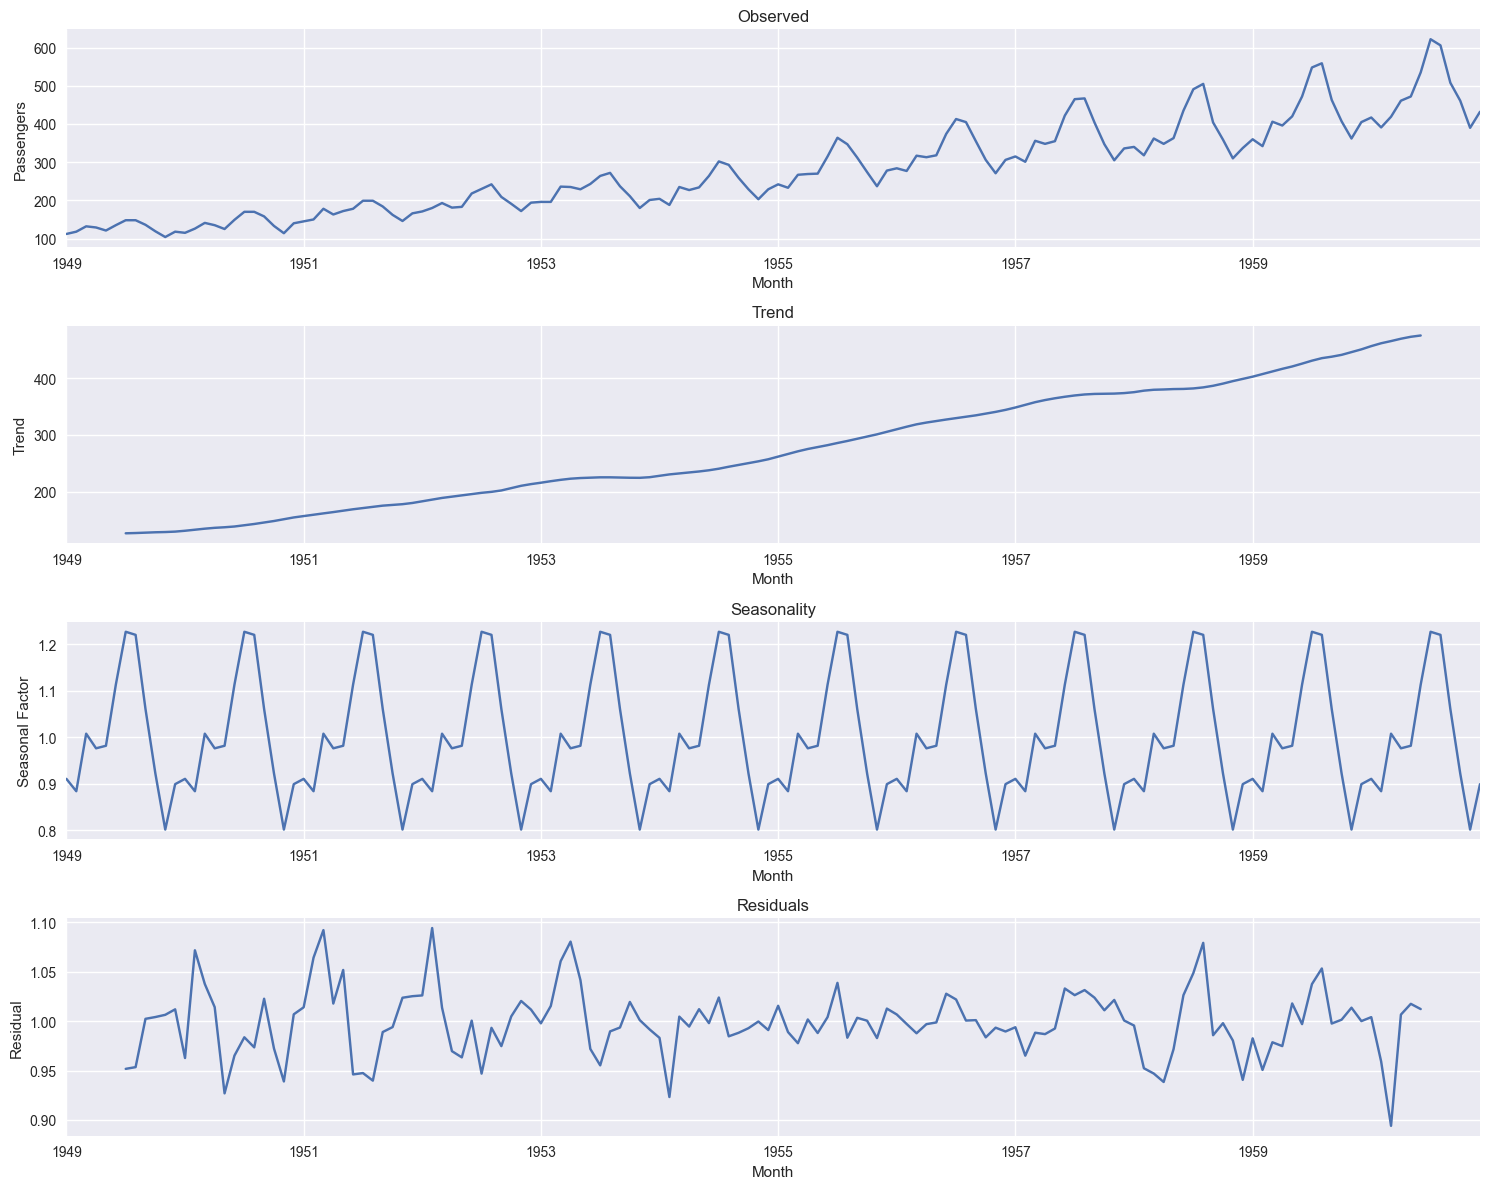

In [31]:
# Import time series analysis tools
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the index to Month for time series analysis
ts_data = data.set_index('Month')['Passengers']

# Decompose the time series
decomposition = seasonal_decompose(ts_data, model='multiplicative', period=12)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Passengers')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_ylabel('Seasonal Factor')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

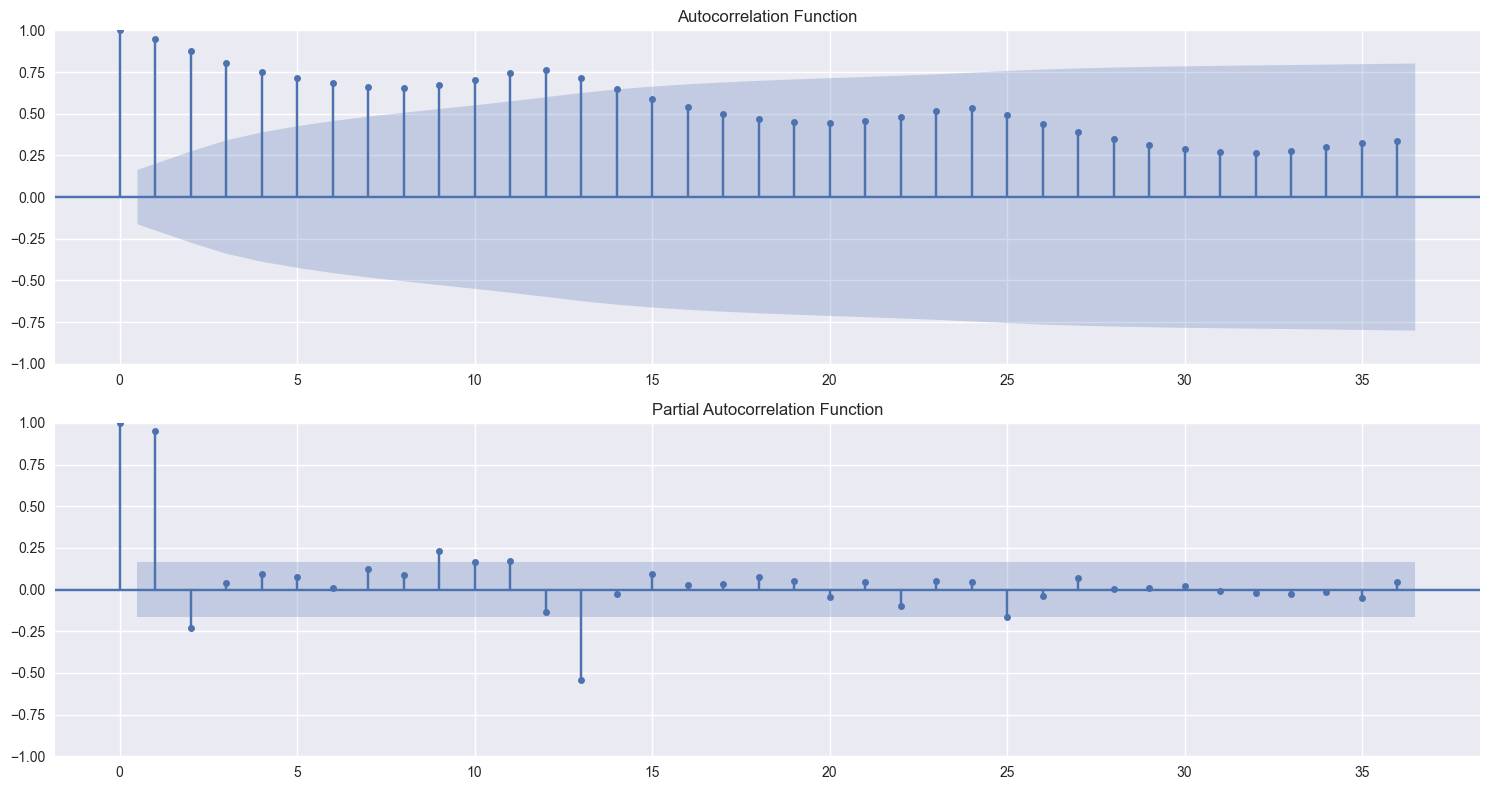

In [32]:
# Plot autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(ts_data, lags=36, ax=ax1)
ax1.set_title('Autocorrelation Function')
plot_pacf(ts_data, lags=36, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [33]:
# Create a DataFrame for modeling
model_df = data.copy()

# Extract date features
model_df['Year'] = model_df['Month'].dt.year
model_df['Month_Num'] = model_df['Month'].dt.month
model_df['Quarter'] = model_df['Month'].dt.quarter

# Create lag features (previous passenger counts)
for lag in range(1, 13):
    model_df[f'Lag_{lag}'] = model_df['Passengers'].shift(lag)

# Create rolling statistics
model_df['Rolling_Mean_3'] = model_df['Passengers'].rolling(window=3).mean()
model_df['Rolling_Mean_6'] = model_df['Passengers'].rolling(window=6).mean()
model_df['Rolling_Mean_12'] = model_df['Passengers'].rolling(window=12).mean()

# Drop rows with NaN values (caused by lag features)
model_df = model_df.dropna()

print("Features created:")
print(model_df.columns.tolist())
model_df.head()

Features created:
['Month', 'Passengers', 'Year', 'Month_Num', 'Quarter', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Rolling_Mean_3', 'Rolling_Mean_6', 'Rolling_Mean_12']


,Month,Passengers,Year,Month_Num,Quarter,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Rolling_Mean_3,Rolling_Mean_6,Rolling_Mean_12
12,1950-01-31,115,1950,1,1,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,112.333333,123.333333,126.916667
13,1950-02-28,126,1950,2,1,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,119.666667,119.666667,127.583333
14,1950-03-31,141,1950,3,1,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,127.333333,120.500000,128.333333
15,1950-04-30,135,1950,4,2,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,134.000000,123.166667,128.833333
16,1950-05-31,125,1950,5,2,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,133.666667,126.666667,129.166667


In [34]:
# Split the data into training and testing sets
# For time series, we always split by time - using the most recent data for testing
train_size = int(len(model_df)* 0.8)
train_data = model_df.iloc[:train_size]
test_data = model_df.iloc[train_size:]

# Prepare features (X) and target (y) for modeling
X_train = train_data.drop(['Month', 'Passengers'], axis=1)
y_train = train_data['Passengers']
X_test = test_data.drop(['Month', 'Passengers'], axis=1)
y_test = test_data['Passengers']

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Model 2: RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#Model 3: XGBoost
xgb_model = xgb.XGBRegressor(n_estimator = 100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

#Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.2f} passengers")
    print(f"MAE {mae:.2f} passengers")
    print(f"R2: {r2:.4f}")

    return rmse, mae, r2

# Evaluate all models
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")


Linear Regression Performance:
RMSE: 0.00 passengers
MAE 0.00 passengers
R2: 1.0000
Random Forest Performance:
RMSE: 45.36 passengers
MAE 30.67 passengers
R2: 0.6761
XGBoost Performance:
RMSE: 57.28 passengers
MAE 46.79 passengers
R2: 0.4835


/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


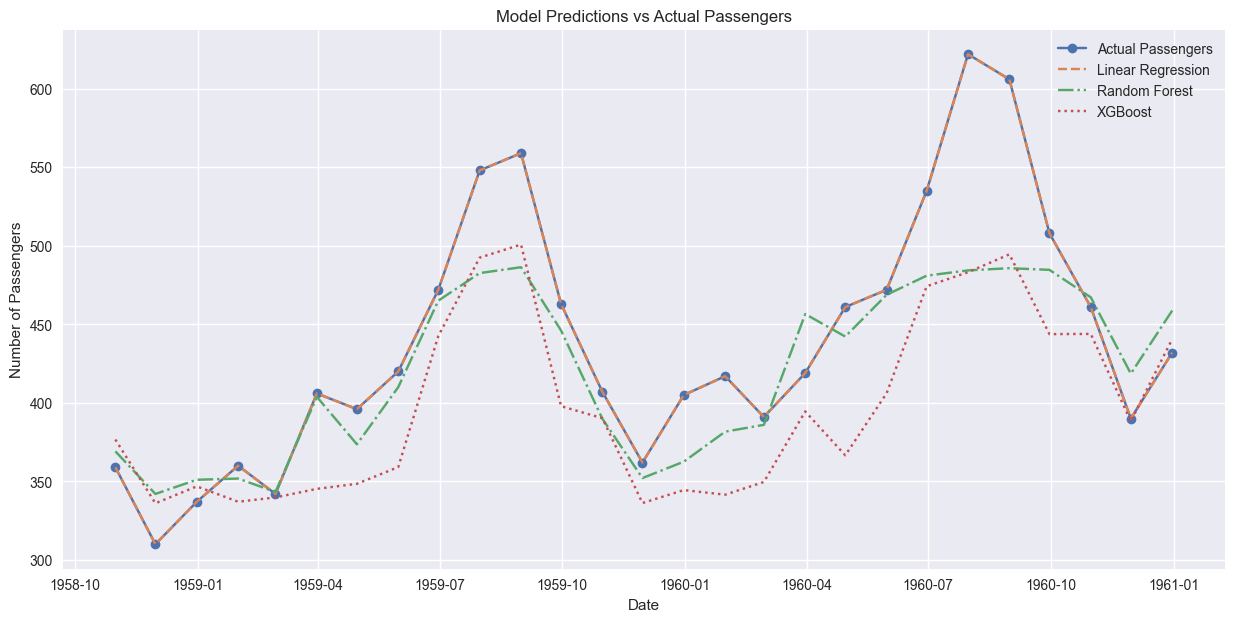

In [36]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 7))
plt.plot(test_data['Month'], y_test, label='Actual Passengers', marker='o')
plt.plot(test_data['Month'], lr_pred, label='Linear Regression', linestyle='--')
plt.plot(test_data['Month'], rf_pred, label='Random Forest', linestyle='-.')
plt.plot(test_data['Month'], xgb_pred, label='XGBoost', linestyle=':')
plt.title('Model Predictions vs Actual Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()